## Imports

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from tempfile import mkdtemp
from shutil import rmtree
import pylab 
import scipy.stats as stats
from xgboost import XGBRegressor



# Sklearn preprocessing
from sklearn.pipeline import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import KNNImputer
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
set_config(display = 'diagram')

## Loading Data



In [2]:
# Load dataset
data = pd.read_csv('data/train.csv',index_col="Id")
X = data.drop(columns=['SalePrice'])
y = data.SalePrice

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.3, random_state=42)

In [4]:
X_train.shape

(438, 79)

In [5]:
y_train.shape

(438,)

In [6]:
X_train.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
90,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal


# 🐣 DATA PREPARATION

##  Initial feature overview

80 features are too much to deal with one by one for a first baseline pipeline! Let's treat them solely based on their `dtype`:

❓ How many numerical features vs. categorical features do we have? 

In [7]:
X_train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [8]:
# Number of numerical features
numerical_features = X_train.select_dtypes(include=['int64','float64'])
numerical_features.shape[1]

36

In [9]:
#Number of categorical features
categorical_features = X_train.select_dtypes(include=['object'])
categorical_features.shape[1]

43

❓ . How many unique categories are there ?

/tmp/ipykernel_68763/2847932215.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_categorical_nunique.values, y=feat_categorical_nunique.index, palette="viridis")


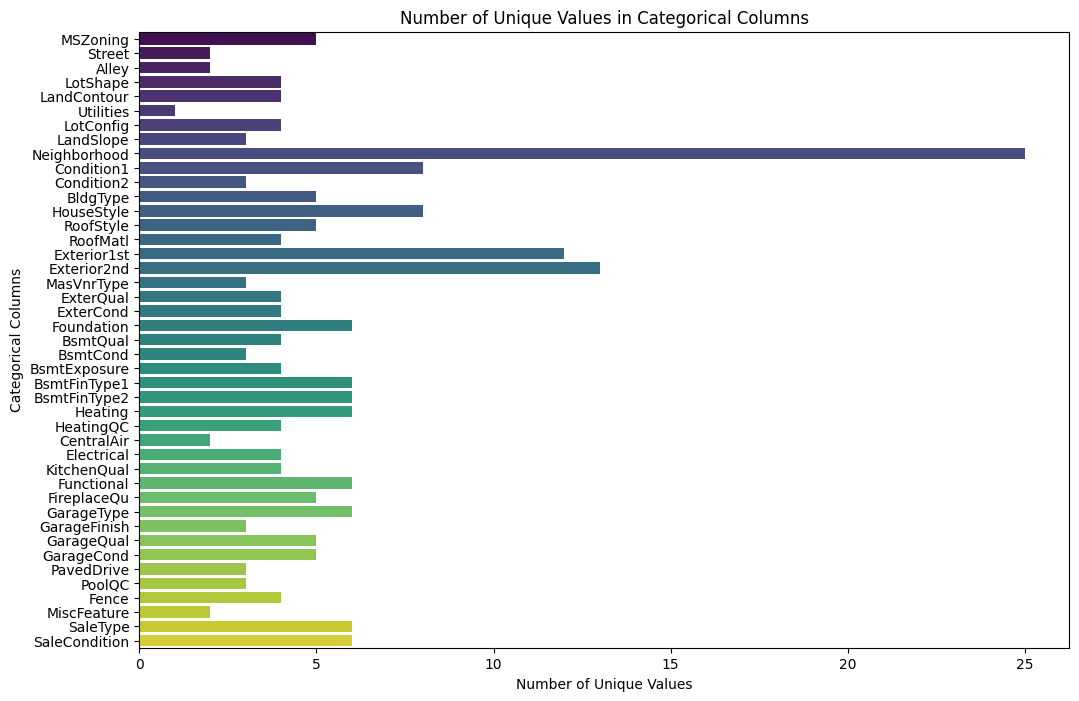

In [10]:
feat_categorical_nunique = X_train.select_dtypes(include=['object']).apply(pd.Series.nunique)

#bar plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=feat_categorical_nunique.values, y=feat_categorical_nunique.index, palette="viridis")
plt.xlabel('Number of Unique Values')
plt.ylabel('Categorical Columns')
plt.title('Number of Unique Values in Categorical Columns')
plt.show()

🤔 If we were to `OneHotEncode` all categorical features, our feature matrix  would become pretty big and sparse, with almost 300 (highly correlated) features for only 1400 observations. Ideally, we should aim at feeding our model with a maximum of ~50 features.

To deal with the high amount of features we are going to use 2 main strategies: **Removing features and Ordinally encode.**


## Treat Cyclical Features

❓ We have some time-based features, we will **transform them** into cyclical features:

In [11]:
# Treat cyclical features
months_in_a_year = 12

X_train['sin_MoSold'] = np.sin(2 * np.pi * (X_train.MoSold - 1) / months_in_a_year)
X_train['cos_MoSold'] = np.cos(2 * np.pi * (X_train.MoSold - 1) / months_in_a_year)

X_train.drop(columns=['MoSold'], inplace=True)

X_train.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,YrSold,SaleType,SaleCondition,sin_MoSold,cos_MoSold
Id,,,,,,,,,,,,,,,,,,,,,
90,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2007,WD,Normal,-0.5,-0.866025


### d) Target Engineering

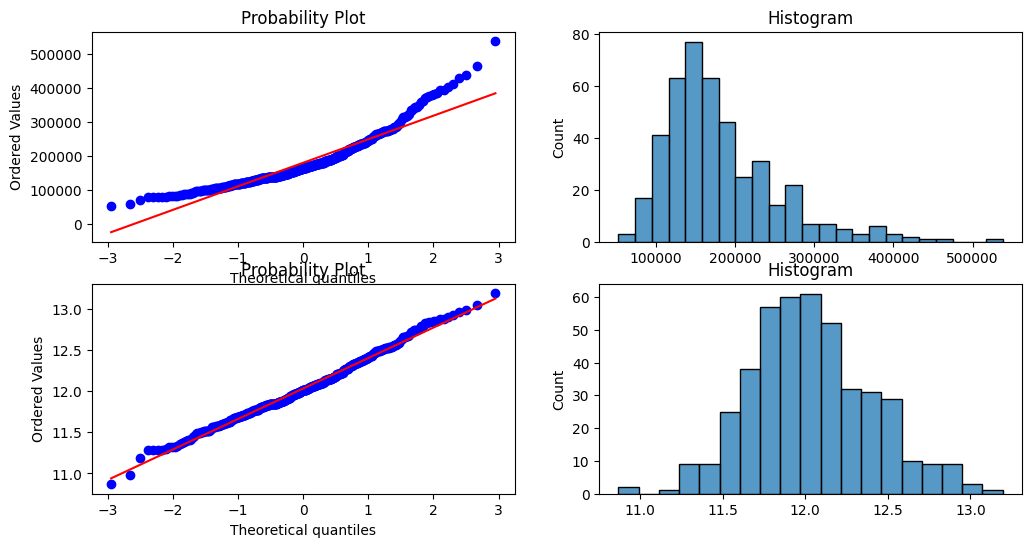

In [12]:
y_log = np.log(y_train.values)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Plot the probability plot in the first subplot
stats.probplot(y_train.values, dist="norm", plot=axs[0,0])
axs[0,0].set_title('Probability Plot')

# Plot the histogram in the second subplot
sns.histplot(y_train.values, ax=axs[0,1])
axs[0,1].set_title('Histogram')

# Plot the probability plot in the first subplot
stats.probplot(y_log, dist="norm", plot=axs[1,0])
axs[1,0].set_title('Probability Plot')

# Plot the histogram in the second subplot
sns.histplot(y_log, ax=axs[1,1])
axs[1,1].set_title('Histogram')

# Show the plots
plt.show()


- Normally distributed variables should be easier to predict with linear or parametric models
- `y_log` is normally distributed


# Encoding 

## Ordinal Encoding

In [13]:
# Features that need to be ordinal encoded

# Overall Quality and Condition
OverallQual = [
    'missing',
    'Very Poor',
    'Poor',
    'Fair',
    'Below Average',
    'Average',
    'Above Average',
    'Good',
    'Very Good',
    'Excellent',
    'Very Excellent'
]

OverallCond = OverallQual  # Since the mapping is the same

# Exterior Quality and Condition
ExterQual = [
    'missing',
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Average/Typical
    'Gd',  # Good
    'Ex'   # Excellent
]

ExterCond = ExterQual  # Since the mapping is the same

# Basement Quality
BsmtQual = [
    'missing',
    'NA',  # No Basement
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Typical
    'Gd',  # Good
    'Ex'   # Excellent
]

# Basement Condition
BsmtCond = [
    'missing',
    'NA',  # No Basement
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Typical - slight dampness allowed
    'Gd',  # Good
    'Ex'   # Excellent
]

# Basement Exposure
BsmtExposure = [
    'missing',
    'NA',  # No Basement
    'No',  # No Exposure
    'Mn',  # Minimum Exposure
    'Av',  # Average Exposure
    'Gd'   # Good Exposure
]

# Basement Finished Type 1
BsmtFinType1 = [
    'missing',
    'NA',  # No Basement
    'Unf', # Unfinished
    'LwQ', # Low Quality
    'Rec', # Average Rec Room
    'BLQ', # Below Average Living Quarters
    'ALQ', # Average Living Quarters
    'GLQ'  # Good Living Quarters
]

# Heating Quality and Condition
HeatingQC = [
    'missing',
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Average/Typical
    'Gd',  # Good
    'Ex'   # Excellent
]

# Kitchen Quality
KitchenQual = [
    'missing',
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Typical/Average
    'Gd',  # Good
    'Ex'   # Excellent
]

# Fireplace Quality
FireplaceQu = [
    'missing',
    'NA',  # No Fireplace
    'Po',  # Poor - Ben Franklin Stove
    'Fa',  # Fair - Prefabricated Fireplace in basement
    'TA',  # Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
    'Gd',  # Good - Masonry Fireplace in main level
    'Ex'   # Excellent - Exceptional Masonry Fireplace
]

# Garage Finish
GarageFinish = [
    'missing',
    'NA',  # No Garage
    'Unf', # Unfinished
    'RFn', # Rough Finished
    'Fin'  # Finished
]

# Garage Quality
GarageQual = [
    'missing',
    'NA',  # No Garage
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Typical/Average
    'Gd',  # Good
    'Ex'   # Excellent
]

# Garage Condition
GarageCond = [
    'missing',
    'NA',  # No Garage
    'Po',  # Poor
    'Fa',  # Fair
    'TA',  # Typical/Average
    'Gd',  # Good
    'Ex'   # Excellent
]

# Pool Quality
PoolQC = [
    'missing',
    'NA',  # No Pool
    'Fa',  # Fair
    'TA',  # Average/Typical
    'Gd',  # Good
    'Ex'   # Excellent
]

# Fence Quality
Fence = [
    'missing',
    'NA',   # No Fence
    'MnWw', # Minimum Wood/Wire
    'GdWo', # Good Wood
    'MnPrv',# Minimum Privacy
    'GdPrv' # Good Privacy
]


In [14]:
#list of ordinal features
ordinal_features = [
    'OverallQual',
    'OverallCond',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'KitchenQual',
    'FireplaceQu',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PoolQC',
    'Fence'
]

In [15]:
#ordinal encoder
encoder_ordinal = OrdinalEncoder(
    categories=[OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,
                FireplaceQu, GarageFinish, GarageQual, GarageCond, PoolQC,Fence],
    dtype=np.int64,
    handle_unknown="use_encoded_value",
    unknown_value=-1 #considers unknown values as worse than missing
)

preproc_ordinal = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    encoder_ordinal,
    MinMaxScaler()
)

## OneHot encoding

In [16]:
# List of feature to one hot encode: removing the ones that need to be ordinal encoded

nominal_features = [item for item in categorical_features if item not in ordinal_features]

#onehot encoding 

preproc_nominal = make_pipeline(
    (SimpleImputer(strategy = "most_frequent")),
    (OneHotEncoder(handle_unknown = "ignore", sparse_output=False))
)


## Numerical encoding

In [17]:
#numerical encoding

preproc_numerical = make_pipeline(
    KNNImputer(),
    MinMaxScaler()
)

In [18]:
#joining pipelines

preproc_transformer = make_column_transformer(
    (preproc_numerical,make_column_selector(dtype_include = ["float64", "int64"])),
    (preproc_nominal, nominal_features),
    (preproc_ordinal, ordinal_features),
    remainder = 'drop'
)

## Statistical Feature Selection 

 <font color=green>Multivariate</font> Feature Selection

In [19]:
preproc_selector_multi = SelectFromModel(
    RandomForestRegressor(),
    threshold = "median", # drop all multivariate features lower than the median correlation
)

preproc_multi = make_pipeline(
    preproc_transformer,
    preproc_selector_multi
)

preproc_multi

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('knnimputer',
                                                                   KNNImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2a1fd6f730>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   On...
                                                                                  unknown_value=-1)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['OverallQual', 'OverallCond',
                                                   'ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1', 'HeatingQC',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('selectfrommodel',
                 SelectFromModel(estimator=RandomForestRegressor(),
                                 threshold='median'))])

# Scoring Metric


1. Create a scorer called `rmsle` using [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) that can be passed as a value for the `scoring` `kwarg` like so:  
    ```python
    cross_val_score(pipe_baseline, X, y, cv=5, scoring=rmsle)
    ```
2.  Create its negative counterpart, `rmsle_neg`, which is best when _maximized_; this will come in handy later as `GridSearchCV` always tries to _maximize_ a score 
    ```python
    GridSearchCV(pipe_baseline, param_grid=..., cv=5, scoring=rmsle_neg)
    ```

RMSLE formula

$$\text{RMSLE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (\log_e (1 + y_i) - \log_e (1 + \hat{y}_i) )^2.}$$

In [20]:

# This is our metric to minimize
rmse = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmse_neg = make_scorer(lambda y_true, y_pred: -1*mean_squared_error(y_true, y_pred)**0.5)

# Model Iteration ♻: XGBOOST

In [21]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import uniform, randint

# Instantiate the model
model_xgb = XGBRegressor()

# Define the parameter grid
param_dist = {
    'xgbregressor__max_depth': randint(3, 15),
    'xgbregressor__n_estimators': randint(100, 500),
    'xgbregressor__learning_rate': uniform(0.01, 0.2),
    'xgbregressor__gamma': uniform(0, 0.5)
}

# Create the pipeline
pipe_xgb = make_pipeline(preproc_multi, model_xgb)

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(pipe_xgb, param_distributions=param_dist,
                                   n_iter=50, scoring=rmse_neg,
                                   cv=5, verbose=1, n_jobs=-1, random_state=42,error_score='raise')

# Fit the RandomizedSearchCV object
random_search.fit(X_train, y_log)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)

# Evaluate the best model
best_model = random_search.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'xgbregressor__gamma': 0.007983126110107097, 'xgbregressor__learning_rate': 0.056178765124429805, 'xgbregressor__max_depth': 14, 'xgbregressor__n_estimators': 466}


In [22]:
score = cross_val_score(best_model, X_train, y_log, cv=5, scoring=rmse, n_jobs=-1).mean()
print("Cross-validated score of the best model: ", score)

Cross-validated score of the best model:  0.13032149345409386


# 🏅PERFORMANCE

In [23]:
X_test.shape

(1022, 79)

In [24]:
X_test.head(1)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal


In [25]:
# Adding columns to X_test according to what we did to X
X_test['sin_MoSold'] = np.sin(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)
X_test['cos_MoSold'] = np.cos(2 * np.pi * (X_test.MoSold - 1) / months_in_a_year)

X_test.drop(columns=['MoSold'], inplace=True)

In [26]:
predictions_log = best_model.predict(X_test)
predictions = np.exp(predictions_log)

In [27]:
rmsle = np.sqrt(mean_squared_log_error(y_test, predictions))
print("RMSLE:", rmsle)

RMSLE: 0.15371332969717938


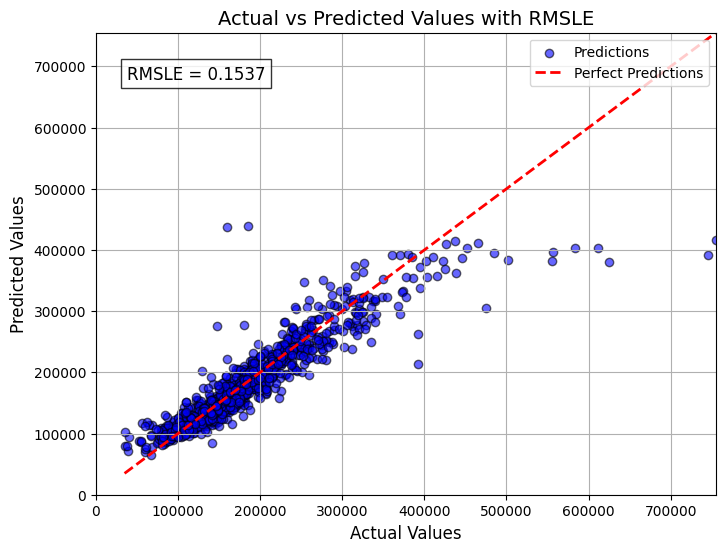

In [30]:
# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color="blue", edgecolor="k", label="Predictions")

# Perfect predictions reference line (45° line)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         color="red", linestyle="--", linewidth=2, label="Perfect Predictions")

# Set axis limits for better visualization
plt.xlim(0, max(y_test.max(), predictions.max()))
plt.ylim(0, max(y_test.max(), predictions.max()))

# Add titles and labels
plt.title("Actual vs Predicted Values with RMSLE", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)

# Add RMSLE annotation
plt.text(0.05 * max(y_test.max(), predictions.max()), 
         0.9 * max(y_test.max(), predictions.max()), 
         f"RMSLE = {rmsle:.4f}", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Add legend and grid
plt.legend(loc="upper right", fontsize=10)
plt.grid(True)

# Show the plot
plt.show()